# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 1 hour**. For this time interval, using the values of the **6 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train an LSTM network.**



Features:

* TimePeriod: Time window of ten minutes.
* WT: Weather Temperature.
* WH: Weather Humidity.
* WS: Wind Speed.
* GDF: General Diffuse Flow. “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DF: DiffuseFlows

Target:

Consumption

## Dateset links:
 * [DS1](https://drive.google.com/file/d/1-8neeIpiq6yzWVw4EG_WgzHX4kPH1n1j/view?usp=sharing)
 * [DS2](https://drive.google.com/file/d/1-LhrUaH59q8O0SYB8WE-Eov2gaTMQYVx/view?usp=sharing)

## Read the datasets

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras

In [52]:
data1 = pd.read_csv('/content/power_consumption_g2.csv')
data2 = pd.read_csv('/content/power_consumption_g2_feat.csv')

In [53]:
data1.head()

,TimePeriod,Consumption
0,2017-12-02 20:10:00,36824.33460
1,2017-12-25 15:30:00,31841.82510
2,2017-05-19 21:10:00,44909.11475
3,2017-05-28 04:50:00,22964.45902
4,2017-05-08 16:10:00,33829.77049


In [54]:
data2.head()

,TimePeriod,WT,WH,WS,GDF,DF
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322
3,2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111
4,2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900


## Merge the datasets (and pre-process if needed)

In [55]:
df = data1.merge(data2, how='left', on='TimePeriod')

In [56]:
df.isnull().sum()

TimePeriod       0
Consumption      0
WT             559
WH             499
WS             529
GDF            524
DF             505
dtype: int64

In [57]:
df['WT'] = df['WT'].fillna(value=df['WT'].mean());
df['WH'] = df['WH'].fillna(value=df['WH'].mean());
df['WS'] = df['WS'].fillna(value=df['WS'].mean());
df['GDF'] = df['GDF'].fillna(value=df['GDF'].mean());
df['DF'] = df['DF'].fillna(value=df['DF'].mean());

In [58]:
df.isnull().sum()

TimePeriod     0
Consumption    0
WT             0
WH             0
WS             0
GDF            0
DF             0
dtype: int64

## Group the datasets into time intervals of 1 hour

In [59]:
df['TimePeriod'] = pd.to_datetime(df['TimePeriod']);

In [60]:
df = df.sort_values(by='TimePeriod')

In [61]:
df.head(10)

,TimePeriod,Consumption,WT,WH,WS,GDF,DF
22869,2017-01-01 00:00:00,34055.69620,6.559000,73.80000,0.083,0.051,0.119
5406,2017-01-01 00:10:00,29814.68354,6.414000,74.50000,0.083,0.070,0.085
46586,2017-01-01 00:20:00,29128.10127,6.313000,74.50000,0.080,0.062,0.100
29105,2017-01-01 00:30:00,28228.86076,6.121000,75.00000,0.083,0.091,0.096
45564,2017-01-01 00:40:00,27335.69620,5.921000,75.70000,0.081,0.048,0.085
43965,2017-01-01 00:50:00,26624.81013,18.813678,76.90000,0.081,0.059,0.108
26762,2017-01-01 01:00:00,25998.98734,5.641000,77.70000,0.080,0.048,0.096
8326,2017-01-01 01:10:00,25446.07595,5.496000,68.26512,0.085,0.055,0.093
28488,2017-01-01 01:20:00,24777.72152,5.678000,78.10000,0.081,0.066,0.141
12441,2017-01-01 01:30:00,24279.49367,5.491000,77.30000,0.082,0.062,0.111


In [62]:
hourly = df.groupby(pd.Grouper(key='TimePeriod', freq='1H'))

In [63]:
hourly.size()

TimePeriod
2017-01-01 00:00:00    6
2017-01-01 01:00:00    6
2017-01-01 02:00:00    6
2017-01-01 03:00:00    6
2017-01-01 04:00:00    6
                      ..
2017-12-30 19:00:00    6
2017-12-30 20:00:00    6
2017-12-30 21:00:00    6
2017-12-30 22:00:00    6
2017-12-30 23:00:00    6
Freq: H, Length: 8736, dtype: int64

## Create lags

In [64]:
lag = 6

In [65]:
for i in range(1, lag + 1):
  df[f'observations_{i}'] = df['Consumption'].shift(i)

In [66]:
df.head()

,TimePeriod,Consumption,WT,WH,WS,GDF,DF,observations_1,observations_2,observations_3,observations_4,observations_5,observations_6
22869,2017-01-01 00:00:00,34055.69620,6.559,73.8,0.083,0.051,0.119,NaN,NaN,NaN,NaN,NaN,NaN
5406,2017-01-01 00:10:00,29814.68354,6.414,74.5,0.083,0.070,0.085,34055.69620,NaN,NaN,NaN,NaN,NaN
46586,2017-01-01 00:20:00,29128.10127,6.313,74.5,0.080,0.062,0.100,29814.68354,34055.69620,NaN,NaN,NaN,NaN
29105,2017-01-01 00:30:00,28228.86076,6.121,75.0,0.083,0.091,0.096,29128.10127,29814.68354,34055.69620,NaN,NaN,NaN
45564,2017-01-01 00:40:00,27335.69620,5.921,75.7,0.081,0.048,0.085,28228.86076,29128.10127,29814.68354,34055.6962,NaN,NaN


In [67]:
df=df.dropna(axis=0)

In [68]:
df.head()

,TimePeriod,Consumption,WT,WH,WS,GDF,DF,observations_1,observations_2,observations_3,observations_4,observations_5,observations_6
26762,2017-01-01 01:00:00,25998.98734,5.641,77.70000,0.080,0.048,0.096,26624.81013,27335.69620,28228.86076,29128.10127,29814.68354,34055.69620
8326,2017-01-01 01:10:00,25446.07595,5.496,68.26512,0.085,0.055,0.093,25998.98734,26624.81013,27335.69620,28228.86076,29128.10127,29814.68354
28488,2017-01-01 01:20:00,24777.72152,5.678,78.10000,0.081,0.066,0.141,25446.07595,25998.98734,26624.81013,27335.69620,28228.86076,29128.10127
12441,2017-01-01 01:30:00,24279.49367,5.491,77.30000,0.082,0.062,0.111,24777.72152,25446.07595,25998.98734,26624.81013,27335.69620,28228.86076
18988,2017-01-01 01:40:00,23896.70886,5.516,77.50000,0.081,0.051,0.108,24279.49367,24777.72152,25446.07595,25998.98734,26624.81013,27335.69620


# Split the dataset into 80% training and 20% testing datasets

In [69]:
features = ['observations_1','observations_2','observations_3','observations_4','observations_5','observations_6']

In [70]:
X,Y = df[features], df['Consumption']

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

In [72]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

In [73]:
X_train.shape

(41928, 6)

## Create the model, pre-process the data and make it suitable for training

In [74]:
 X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
 X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
 X_train.shape

(41928, 6, 1)

## Train the model, use 20% of the training dataset for validation
Train with 10 epochs (due to time limit)

In [75]:
model = Sequential()
model.add(LSTM(100,  activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50,  activation='relu'))
model.add(Dense(1, activation='linear'))

In [76]:
model.compile(loss=keras.losses.MeanSquaredError() , optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError() ])

In [77]:
history = model.fit(X_train, Y_train, batch_size=16, validation_split=0.2, epochs=10, shuffle=False)

Epoch 1/10
2097/2097 [==============================] - 27s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0244 - val_loss: 6.5824e-04 - val_mean_squared_error: 6.5824e-04 - val_mean_absolute_error: 0.0209
Epoch 2/10
2097/2097 [==============================] - 22s 11ms/step - loss: 3.0156e-04 - mean_squared_error: 3.0156e-04 - mean_absolute_error: 0.0123 - val_loss: 5.4731e-04 - val_mean_squared_error: 5.4731e-04 - val_mean_absolute_error: 0.0189
Epoch 3/10
2097/2097 [==============================] - 21s 10ms/step - loss: 2.7368e-04 - mean_squared_error: 2.7368e-04 - mean_absolute_error: 0.0117 - val_loss: 3.8369e-04 - val_mean_squared_error: 3.8369e-04 - val_mean_absolute_error: 0.0151
Epoch 4/10
2097/2097 [==============================] - 23s 11ms/step - loss: 2.5314e-04 - mean_squared_error: 2.5314e-04 - mean_absolute_error: 0.0112 - val_loss: 3.0514e-04 - val_mean_squared_error: 3.0514e-04 - val_mean_absolute_error: 0.0129
Epoch 5/10
2097/2097 [==

## Plot the loss function on the training and validation dataset

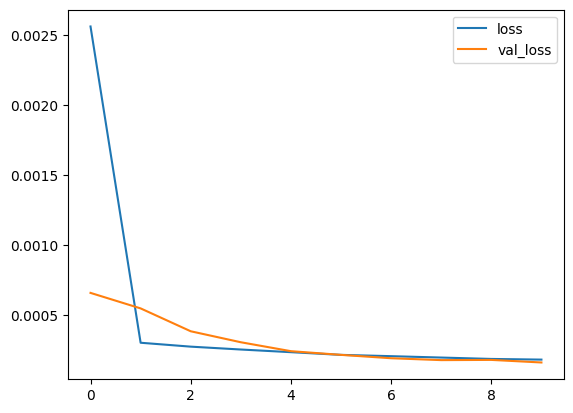

In [81]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

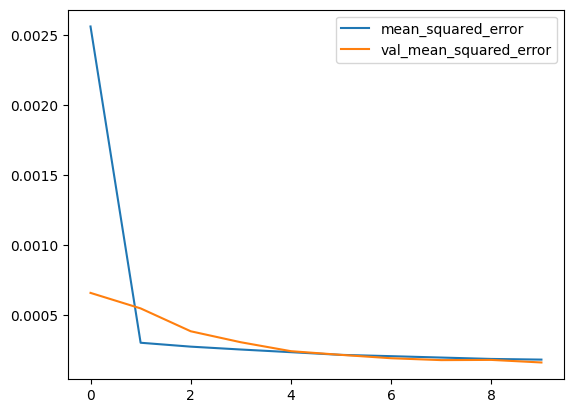

In [80]:
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.legend()
plt.show()

## Calculate the adequate metrics

In [82]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 100)            40800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Visualize the targets against the predictions

In [83]:
 preds = model.predict(X_test)

328/328 [==============================] - 10s 4ms/step


In [84]:
preds = scaler.inverse_transform(preds)

In [85]:
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(231206.38764305497, 329.0474482020666, 0.9953585617334896)

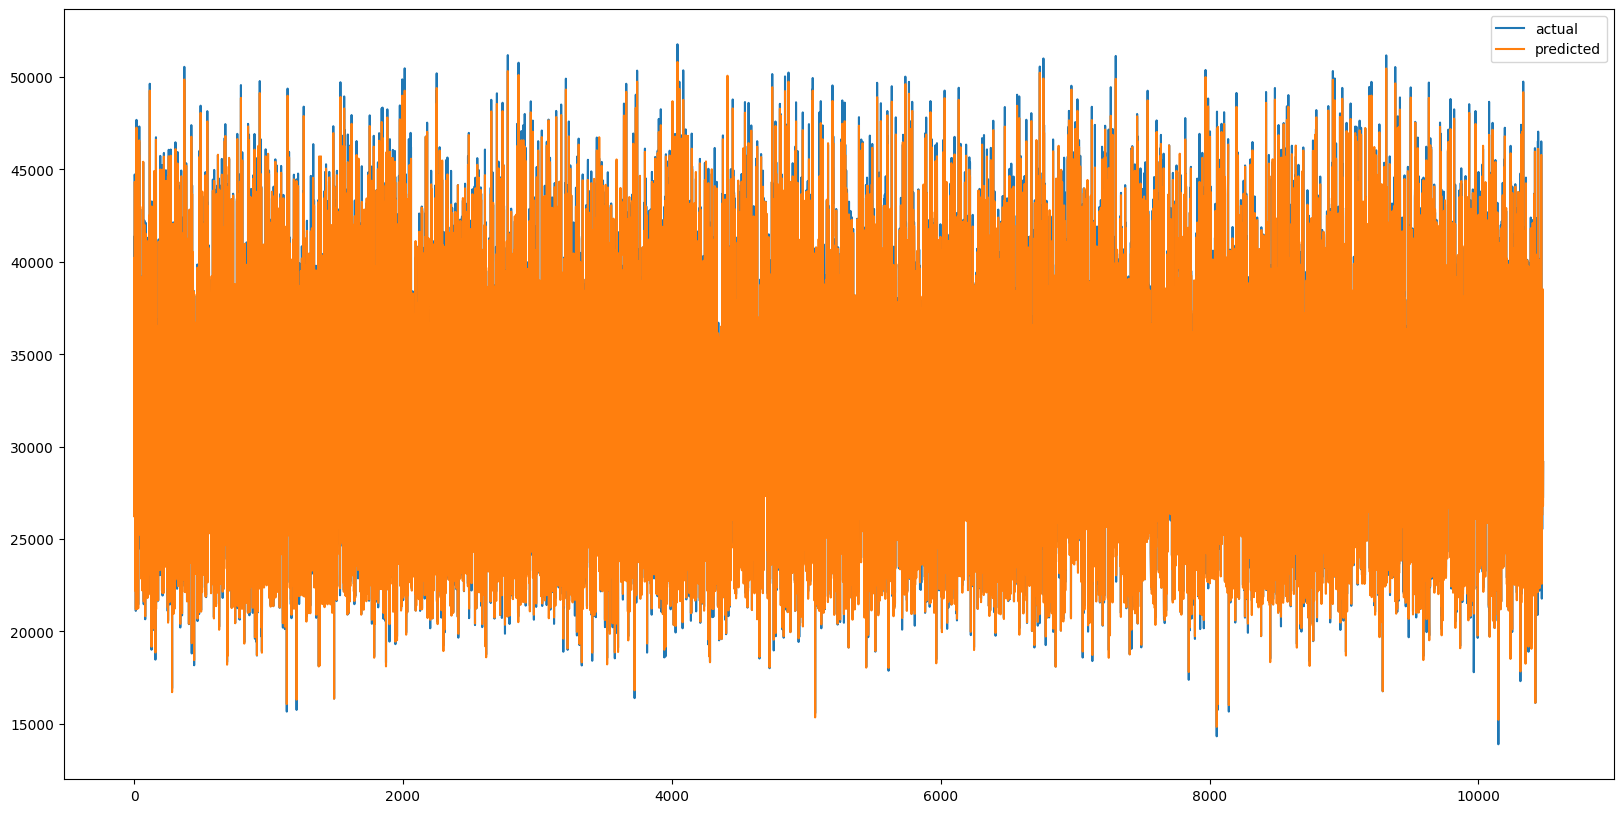

In [86]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()